In [1]:
from sqlalchemy.dialects.mssql.information_schema import columns

'''
Grundsätzlich hat das Datenset bereits eine gute Qualität, sodass nicht viel zu bereinigen ist. Dennoch sind einige Schritte zu erledigen. Dies umfasst:
- Spalte des Landes anpassen
- Vereinsnamen anpassen für Merging
- Tabelle aufräumen (einige Spieler sind doppelt enthalten, da sie einen Teil der Saison bei Verein 1 und den anderen Teil bei Verein 2 gespielt haben)
- uvm.
'''

'\nGrundsätzlich hat das Datenset bereits eine gute Qualität, sodass nicht viel zu bereinigen ist. Dennoch sind einige Schritte zu erledigen. Dies umfasst:\n- Spalte des Landes anpassen\n- Vereinsnamen anpassen für Merging\n- Tabelle aufräumen (einige Spieler sind doppelt enthalten, da sie einen Teil der Saison bei Verein 1 und den anderen Teil bei Verein 2 gespielt haben)\n- uvm.\n'

In [2]:
import pandas as pd
from pathlib import Path

In [3]:
#Importieren der Daten und erste Überarbeitungen
path = Path("premier-player-23-24.csv")
spieler = pd.read_csv(path)

#Anpassen der "Nation" Spalte - aus "eng ENG" sollten nur "ENG" werden
spieler["Nation"] = spieler["Nation"].str.split().str[1]

#Anpassen der Vereinsnamen, um sie für das Mergen zu cleanen.
rename = {
    "Tottenham Hotspur": "Tottenham",
    "West Ham United":"West Ham",
    "Sheffield United":"Sheffield",
}
spieler["Team"] = spieler["Team"].replace(rename)

# Herausziehen der relevanten Spalten
spieler = spieler[["Player", "Team", "Nation","Pos","Age","MP","Starts","Min","90s","Gls","Ast","G+A","G-PK","PK","PKatt","CrdY","CrdR","xG","npxG","xAG","PrgC","PrgP","PrgR"]]

#Umbenennung der Spalten
rename_cols = {
    "Player": "Player",
    "Team": "Team",
    "Nation": "Nation",
    "Pos": "Position",
    "Age": "Age",
    "MP": "Matches Played",
    "Starts": "Starts",
    "Min": "Minutes Played",
    "90s": "90 Mins Played",
    "Gls": "Goals",
    "Ast": "Assists",
    "G+A": "Goals + Assists",
    "G-PK":"Goals no Penalty",
    "PK": "Penalties",
    "PKatt": "Penalties Attempted",
    "CrdY": "Yellow Card",
    "CrdR": "Red Card",
    "xG": "xG",
    "npxG": "no pen xG",
    "xAG": "xAG",
}

spieler.rename(columns=rename_cols, inplace=True)

spieler

,Player,Team,Nation,Position,Age,Matches Played,Starts,Minutes Played,90 Mins Played,Goals,...,Penalties,Penalties Attempted,Yellow Card,Red Card,xG,no pen xG,xAG,PrgC,PrgP,PrgR
0,Rodri,Manchester City,ESP,MF,27.0,34,34,2931.0,32.6,8.0,...,0.0,0.0,8.0,1.0,4.1,4.1,3.9,76.0,376.0,55.0
1,Phil Foden,Manchester City,ENG,"FW,MF",23.0,35,33,2857.0,31.7,19.0,...,0.0,0.0,2.0,0.0,10.3,10.3,8.4,93.0,168.0,269.0
2,Ederson,Manchester City,BRA,GK,29.0,33,33,2785.0,30.9,0.0,...,0.0,0.0,5.0,0.0,0.0,0.0,0.1,0.0,4.0,0.0
3,Julián Álvarez,Manchester City,ARG,"MF,FW",23.0,36,31,2647.0,29.4,11.0,...,2.0,2.0,2.0,0.0,13.0,11.5,6.4,64.0,103.0,180.0
4,Kyle Walker,Manchester City,ENG,DF,33.0,32,30,2767.0,30.7,0.0,...,0.0,0.0,2.0,0.0,0.4,0.4,2.6,74.0,157.0,172.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
575,Sam Curtis,Sheffield,IRL,DF,17.0,1,0,28.0,0.3,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
576,Daniel Jebbison,Sheffield,ENG,FW,19.0,1,0,21.0,0.2,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
577,Antwoine Hackford,Sheffield,ENG,FW,19.0,2,0,13.0,0.1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
578,Sydie Peck,Sheffield,ENG,MF,18.0,1,0,10.0,0.1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# Nachdem ich nun den Datensatz für mich soweit bereinigt habe, schaue ich mir die erste Analyse an: dafür möchte ich eine weitere Tabelle erstellen, die die SPieler nicht nach Verein trennt (um diesbezüglich Duplikate zu entfernen)

def spieler_no_teams(spieler):
    #1.Schritt: Entfernen der Team Spalte, da diese in dieser Tabelle nicht relevant ist
    spieler = spieler.drop(columns="Team")
    #2. Schritt: Zusammenführen der Werte (exkl. strings)
    spieler = spieler.groupby("Player", as_index=False).agg(
        {col:"first" if col == "Age"
             else "sum" if pd.api.types.is_numeric_dtype(spieler[col]) else "first" for col in spieler.columns if col != "Player"}
    )

    return spieler
spieler_n_T = spieler_no_teams(spieler)
spieler_n_T


,Player,Nation,Position,Age,Matches Played,Starts,Minutes Played,90 Mins Played,Goals,Assists,...,Penalties,Penalties Attempted,Yellow Card,Red Card,xG,no pen xG,xAG,PrgC,PrgP,PrgR
0,Aaron Cresswell,ENG,"DF,FW",33.0,11,4,436.0,4.8,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.4,4.0,26.0,6.0
1,Aaron Hickey,SCO,DF,21.0,9,9,713.0,7.9,0.0,0.0,...,0.0,0.0,5.0,0.0,0.2,0.2,0.1,9.0,21.0,13.0
2,Aaron Ramsdale,ENG,GK,25.0,6,6,540.0,6.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
3,Aaron Ramsey,ENG,"MF,FW",20.0,14,5,527.0,5.9,0.0,0.0,...,0.0,0.0,1.0,0.0,0.3,0.3,0.4,8.0,8.0,17.0
4,Aaron Wan-Bissaka,ENG,DF,25.0,22,20,1780.0,19.8,0.0,2.0,...,0.0,0.0,4.0,0.0,0.1,0.1,1.5,30.0,77.0,54.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
565,Zack Nelson,ENG,"MF,DF",18.0,2,0,7.0,0.1,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
566,Zeki Amdouni,SUI,FW,22.0,34,27,1953.0,21.7,5.0,1.0,...,1.0,1.0,2.0,0.0,5.8,5.0,1.4,63.0,49.0,93.0
567,Álex Moreno,ESP,DF,30.0,21,11,1031.0,11.5,2.0,0.0,...,0.0,0.0,2.0,0.0,1.1,1.1,1.1,32.0,24.0,83.0
568,Đorđe Petrović,SRB,GK,23.0,23,22,1987.0,22.1,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [5]:
'''
Damit haben wir jetzt zwei Tabellen: eine die sich auf Spieler selbst bezieht und eine die sie unter die Teams kategorisiert. Hiermit können wir mit unserer Bearbeitung fortfahren.
'''

'\nDamit haben wir jetzt zwei Tabellen: eine die sich auf Spieler selbst bezieht und eine die sie unter die Teams kategorisiert. Hiermit können wir mit unserer Bearbeitung fortfahren.\n'

In [6]:
#Berechnung der Top 10 Spieler sortiert nach Toren
def top_ten_by_goals(spieler_n_T):
    spieler_n_T = spieler_n_T.sort_values(by="Goals", ascending=False)
    spieler_n_T = spieler_n_T[["Player", "Goals"]]
    return spieler_n_T[:10]
top_ten_by_goals(spieler_n_T)


,Player,Goals
172,Erling Haaland,27.0
114,Cole Palmer,22.0
19,Alexander Isak,21.0
452,Phil Foden,19.0
152,Dominic Solanke,19.0
436,Ollie Watkins,19.0
399,Mohamed Salah,18.0
505,Son Heung-min,17.0
260,Jean-Philippe Mateta,16.0
86,Bukayo Saka,16.0


In [7]:
#Berechnung der Top 10 Spieler sortiert nach Vorlagen
def top_ten_by_assists(spieler_n_T):
    spieler_n_T = spieler_n_T.sort_values(by="Assists", ascending=False)
    spieler_n_T = spieler_n_T[["Player", "Assists"]]
    return spieler_n_T[:10]
top_ten_by_assists(spieler_n_T)

,Player,Assists
436,Ollie Watkins,13.0
114,Cole Palmer,11.0
402,Morgan Gibbs-White,10.0
312,Kevin De Bruyne,10.0
399,Mohamed Salah,10.0
44,Anthony Gordon,10.0
315,Kieran Trippier,10.0
364,Martin Ødegaard,10.0
81,Brennan Johnson,10.0
445,Pascal Groß,10.0


In [8]:
#Berechnung der Top 10 Spieler sortiert nach Toren und Assists
def top_ten_by_goals_and_assists(spieler_n_T):
    spieler_n_T = spieler_n_T.sort_values(by="Goals + Assists", ascending=False)
    spieler_n_T = spieler_n_T[["Player", "Goals + Assists"]]
    return spieler_n_T[:10]
top_ten_by_goals_and_assists(spieler_n_T)

,Player,Goals + Assists
114,Cole Palmer,33.0
436,Ollie Watkins,32.0
172,Erling Haaland,32.0
399,Mohamed Salah,28.0
505,Son Heung-min,27.0
452,Phil Foden,27.0
86,Bukayo Saka,25.0
19,Alexander Isak,23.0
254,Jarrod Bowen,22.0
152,Dominic Solanke,22.0


In [9]:
#Berechnung der Top 10 Spieler sortiert nach gespielten Minuten
def top_ten_by_minutes_played(spieler_n_T):
    spieler_n_T = spieler_n_T.sort_values(by="Minutes Played", ascending=False)
    spieler_n_T = spieler_n_T[["Player", "Minutes Played", "Position"]]
    return spieler_n_T[:10]
top_ten_by_minutes_played(spieler_n_T)

,Player,Minutes Played,Position
285,Jordan Pickford,3420.0,GK
72,Bernd Leno,3420.0,GK
554,William Saliba,3420.0,DF
38,André Onana,3420.0,GK
382,Max Kilman,3420.0,DF
197,Guglielmo Vicario,3420.0,GK
246,James Tarkowski,3419.0,DF
268,Joachim Andersen,3415.0,DF
521,Thomas Kaminski,3405.0,GK
217,Illia Zabarnyi,3330.0,DF


In [10]:
#Berechnung der Overperformance (wer hat mehr Tore geschossen als auf Basis seiner Chancen erwartet?)
def xG_difference_top(spieler_n_T):
    spieler_n_T = spieler_n_T[["Player", "Goals","xG"]].copy()
    spieler_n_T["AbsDiff"] = spieler_n_T["Goals"] - spieler_n_T["xG"]
    spieler_n_T = spieler_n_T.sort_values(by="AbsDiff", ascending=False)
    return spieler_n_T[:10]
xG_difference_top(spieler_n_T)

,Player,Goals,xG,AbsDiff
452,Phil Foden,19.0,10.3,8.7
88,Callum Hudson-Odoi,8.0,2.7,5.3
260,Jean-Philippe Mateta,16.0,10.9,5.1
505,Son Heung-min,17.0,12.0,5.0
147,Diogo Jota,10.0,5.3,4.7
390,Michael Olise,10.0,5.5,4.5
254,Jarrod Bowen,16.0,11.6,4.4
211,Hwang Hee-chan,12.0,7.7,4.3
161,Elijah Adebayo,10.0,5.9,4.1
323,Leandro Trossard,12.0,7.9,4.1


In [11]:
#Berechnung der Underperformance (wer hat weniger Tore geschossen als auf Basis seiner Chancen erwartet?)
def xG_difference_flop(spieler_n_T):
    spieler_n_T = spieler_n_T[["Player", "Goals","xG"]].copy()
    spieler_n_T["AbsDiff"] = spieler_n_T["Goals"] - spieler_n_T["xG"]
    spieler_n_T = spieler_n_T.sort_values(by="AbsDiff", ascending=True)
    return spieler_n_T[:10]
xG_difference_flop(spieler_n_T)

,Player,Goals,xG,AbsDiff
150,Dominic Calvert-Lewin,7.0,12.9,-5.9
81,Brennan Johnson,5.0,10.6,-5.6
134,Darwin Núñez,11.0,16.3,-5.3
421,Nicolas Jackson,14.0,18.6,-4.6
341,Luis Díaz,8.0,11.9,-3.9
74,Beto,3.0,6.8,-3.8
310,Keane Lewis-Potter,3.0,6.3,-3.3
170,Enzo Fernández,3.0,6.2,-3.2
399,Mohamed Salah,18.0,21.2,-3.2
295,João Pedro,9.0,11.9,-2.9


In [12]:
'''
Sehr Interessant: Mit Darwin Nunez, Luis Diaz und  Mohammed Salah sind gleich 3 Spieler von Liverpool FC in den Flop 10 ( dies spiegelt auch die Werte der Team Analyse wieder)
Liverpool hat letzte Saison massiv underperformed und hätte auf Basis der Zahlen besser abschneiden müssen - in dieser Saison sieht man bereits ein anderes Bild.
'''

'\nSehr Interessant: Mit Darwin Nunez, Luis Diaz und  Mohammed Salah sind gleich 3 Spieler von Liverpool FC in den Flop 10 ( dies spiegelt auch die Werte der Team Analyse wieder)\nLiverpool hat letzte Saison massiv underperformed und hätte auf Basis der Zahlen besser abschneiden müssen - in dieser Saison sieht man bereits ein anderes Bild.\n'

In [13]:
# Jetzt schaue ich mir an, welcher Spieler für sein Team am wichtigsten war (% der gesamten Tore)
def importance_player(spieler):
    spieler = spieler[["Player", "Goals", "Team"]].copy()

    #Importieren der Abschlusstabelle
    path_tabelle = Path("finale_tabelle.csv")
    tabelle = pd.read_csv(path_tabelle)
    tabelle = tabelle[["Team","Goals"]]

    #Merging der beiden Tabelle um die Statistik zu berechnen
    merged = pd.merge(tabelle, spieler, on="Team", how="right")
    merged = merged.rename(columns={"Team":"Team",
                                    "Goals_x":"Goals Team",
                                    "Goals_y":"Goals Player"})
    merged = merged[["Player","Goals Player","Team","Goals Team"]]
    merged["% of Total"] = merged["Goals Player"]/merged["Goals Team"]*100
    merged = merged.sort_values(by="% of Total", ascending=False)
    return merged
importance_player(spieler)


,Player,Goals Player,Team,Goals Team,% of Total
369,Dominic Solanke,19.0,Bournemouth,54,35.185185
458,Chris Wood,14.0,Nottingham Forest,49,28.571429
83,Cole Palmer,22.0,Chelsea,77,28.571429
6,Erling Haaland,27.0,Manchester City,96,28.125000
265,Jean-Philippe Mateta,16.0,Crystal Palace,57,28.070175
...,...,...,...,...,...
310,Fodé Ballo-Touré,0.0,Fulham,55,0.000000
309,Luke Harris,0.0,Fulham,55,0.000000
308,Armando Broja,0.0,Fulham,55,0.000000
302,Harrison Reed,0.0,Fulham,55,0.000000


In [14]:
# Als nächstes schaue ich mir an, welcher Spieler am wenigsten Zeit gebraucht hat um seine Tore zu schießen. Dazu wird die Anzahl der Minuten durch die Anzahl der Tore dividiert.
def time_for_goals(spieler_n_T):
    spieler_n_T = spieler_n_T[["Player", "Goals","Minutes Played"]].copy()
    #Filtern von Toren (es dürfen nur Spieler hergenommen werden, die zumindest ein Tor geschossen haben
    spieler_n_T = spieler_n_T[spieler_n_T["Goals"] > 0]
    #Berechnung der Spalte
    spieler_n_T["Time for Goals"] = spieler_n_T["Minutes Played"]/spieler_n_T["Goals"]
    #ABschließendes Sortieren
    spieler_n_T = spieler_n_T.sort_values(by="Time for Goals", ascending=True)
    return spieler_n_T[:10]
time_for_goals(spieler_n_T)

,Player,Goals,Minutes Played,Time for Goals
193,George Earthy,1.0,34.0,34.000000
13,Alejo Véliz,1.0,50.0,50.000000
492,Sasa Kalajdzic,2.0,166.0,83.000000
172,Erling Haaland,27.0,2552.0,94.518519
266,Jhon Durán,5.0,475.0,95.000000
19,Alexander Isak,21.0,2255.0,107.380952
314,Kieffer Moore,1.0,108.0,108.000000
89,Callum Wilson,9.0,991.0,110.111111
385,Maxwel Cornet,1.0,112.0,112.000000
147,Diogo Jota,10.0,1145.0,114.500000


In [15]:
'''
Leider ist diese Statistik von "Ausreißern" geprägt. Aber an dritter Stelle steht ein Österreicher.
'''

'\nLeider ist diese Statistik von "Ausreißern" geprägt. Aber an dritter Stelle steht ein Österreicher.\n'

In [16]:
#Welche Nationalität hat die meisten Tore pro Kopf geschossen?
def goals_per_nation_per_person(spieler_n_T):
    spieler_n_T = spieler_n_T[["Player", "Nation", "Goals"]].copy()
    #Zusammenfassung
    aggregation = spieler_n_T.groupby(["Nation"]).agg(
        Players = ("Player", "count"),
        Goals = ("Goals", "sum"),
    )
    aggregation["Goals per Nation per Person"] = aggregation["Goals"]/aggregation["Players"]
    aggregation = aggregation.sort_values(by="Goals per Nation per Person", ascending=False)
    return aggregation
goal_nation_statistic = goals_per_nation_per_person(spieler_n_T)
goal_nation_statistic


,Players,Goals,Goals per Nation per Person
Nation,,,
KOR,2,29.0,14.5
NZL,1,14.0,14.0
EGY,2,18.0,9.0
NOR,5,39.0,7.8
COD,2,12.0,6.0
...,...,...,...
ROU,2,0.0,0.0
KVX,1,0.0,0.0
CRC,1,0.0,0.0


In [17]:
#Nation mit den meisten SPielern
goal_nation_statistic_most_players = goal_nation_statistic.sort_values(by="Players", ascending=False)
goal_nation_statistic_most_players

,Players,Goals,Goals per Nation per Person
Nation,,,
ENG,195,369.0,1.892308
BRA,33,97.0,2.939394
FRA,27,63.0,2.333333
ESP,19,23.0,1.210526
NED,19,36.0,1.894737
...,...,...,...
AUT,1,2.0,2.000000
NZL,1,14.0,14.000000
GRN,1,1.0,1.000000


In [18]:
# Nation mit dem meisten Toren
goal_nation_statistic_most_goals = goal_nation_statistic.sort_values(by="Goals", ascending=False)
goal_nation_statistic_most_goals

,Players,Goals,Goals per Nation per Person
Nation,,,
ENG,195,369.0,1.892308
BRA,33,97.0,2.939394
FRA,27,63.0,2.333333
ARG,14,43.0,3.071429
NOR,5,39.0,7.800000
...,...,...,...
ROU,2,0.0,0.000000
KVX,1,0.0,0.000000
CRC,1,0.0,0.000000


In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

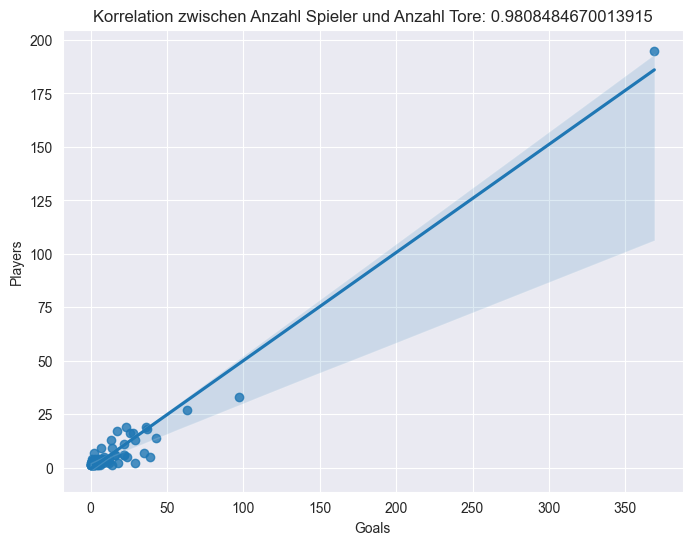

In [20]:
# Überprüfung einer Korrelation zwischen Anzahl Spieler und Anzahl Tore
corr_01 = goal_nation_statistic["Goals"].corr(goal_nation_statistic["Players"])
plt.figure(figsize=(8, 6))
sns.regplot(x=goal_nation_statistic["Goals"], y=goal_nation_statistic["Players"])
plt.title(f"Korrelation zwischen Anzahl Spieler und Anzahl Tore: {corr_01}")
plt.show()

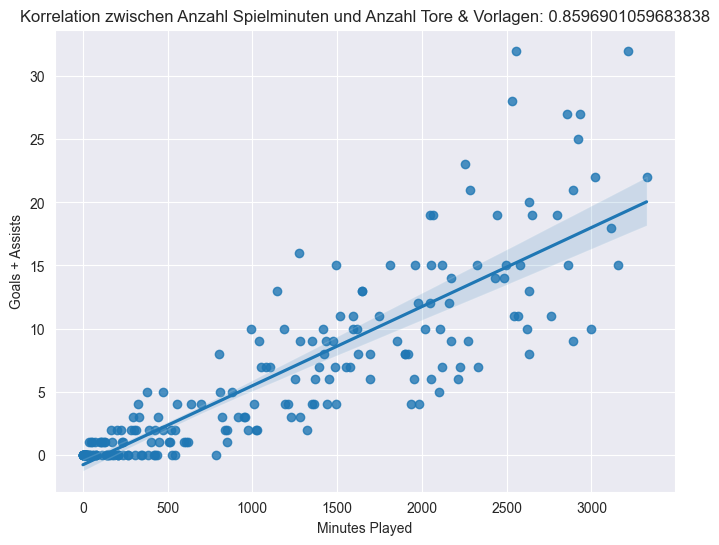

In [21]:
# Wenn ein Spieler als Position ein "FW" ist, gibt es eine Korrelation ziwischen der gespielten Minuten und Goals + Assists
def forward_only(spieler_n_T):
    spieler_n_T = spieler_n_T[spieler_n_T["Position"].str.contains("FW")].copy()
    return spieler_n_T
forward_only(spieler_n_T)
fw = forward_only(spieler_n_T)

#Berechnung der Korrelation
corr_02 = fw["Minutes Played"].corr(fw["Goals + Assists"])
plt.figure(figsize=(8, 6))
sns.regplot(x=fw["Minutes Played"], y=fw["Goals + Assists"])
plt.title(f"Korrelation zwischen Anzahl Spielminuten und Anzahl Tore & Vorlagen: {corr_02}")
plt.show()


In [22]:
# Kartenanalyse - welcher Spieler war am unfairsten?
def kartenanalyse(spieler_n_T):
    kartenstatistik = spieler_n_T[["Player", "Yellow Card", "Red Card","Minutes Played","Age"]].copy()
    kartenstatistik["Aggregated"] = spieler_n_T["Yellow Card"] + spieler_n_T["Red Card"]
    kartenstatistik = kartenstatistik.sort_values(by="Aggregated", ascending=False)
    return kartenstatistik
karten = kartenanalyse(spieler_n_T)
karten

,Player,Yellow Card,Red Card,Minutes Played,Age,Aggregated
44,Anthony Gordon,12.0,1.0,2890.0,22.0,13.0
294,João Palhinha,13.0,0.0,2699.0,28.0,13.0
359,Mario Lemina,12.0,1.0,2968.0,29.0,13.0
356,Marcos Senesi,13.0,0.0,2242.0,26.0,13.0
39,Anel Ahmedhodžić,11.0,1.0,2649.0,24.0,12.0
...,...,...,...,...,...,...
410,Nathan Aké,0.0,0.0,2042.0,28.0,0.0
366,Mason Burstow,0.0,0.0,9.0,19.0,0.0
472,Robin Olsen,0.0,0.0,405.0,33.0,0.0
181,Facundo Pellistri,0.0,0.0,172.0,21.0,0.0


In [23]:
# Kartenanalyse - welcher Spieler hatte die meisten Roten Karten?
def rote_karten(spieler_n_T):
    kartenstatistik = spieler_n_T[["Player", "Yellow Card", "Red Card","Minutes Played"]].copy()
    kartenstatistik["Aggregated"] = spieler_n_T["Yellow Card"] + spieler_n_T["Red Card"]
    kartenstatistik = kartenstatistik.sort_values(by="Red Card", ascending=False)
    return kartenstatistik
rote_karten(spieler_n_T)

,Player,Yellow Card,Red Card,Minutes Played,Aggregated
463,Reece James,2.0,2.0,419.0,4.0
564,Yves Bissouma,10.0,2.0,2068.0,12.0
433,Oliver McBurnie,7.0,2.0,1280.0,9.0
53,Ashley Young,7.0,1.0,2280.0,8.0
119,Cristian Romero,7.0,1.0,2790.0,8.0
...,...,...,...,...,...
194,Gio Reyna,0.0,0.0,235.0,0.0
193,George Earthy,0.0,0.0,34.0,0.0
192,George Baldock,4.0,0.0,969.0,4.0
191,Gabriel Osho,3.0,0.0,1846.0,3.0


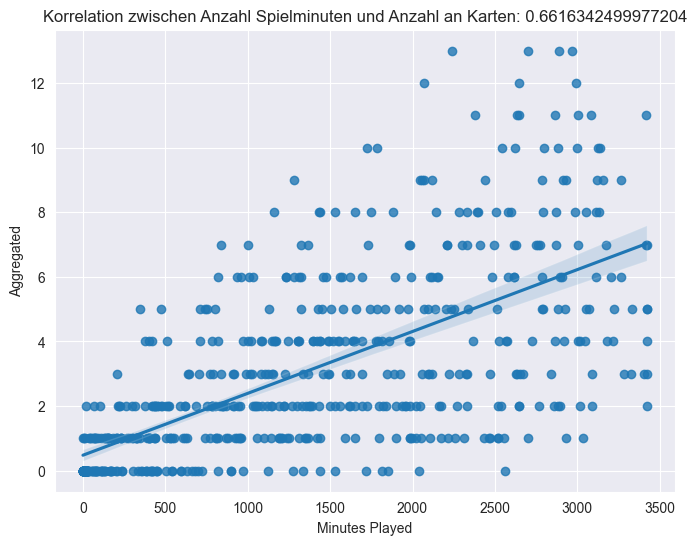

In [24]:
# Gibt es eine Korrelation zwischen Minutes Played und der Anzahl an Karten?
corr_03 = karten["Minutes Played"].corr(karten["Aggregated"])
plt.figure(figsize=(8, 6))
sns.regplot(x=karten["Minutes Played"], y=karten["Aggregated"])
plt.title(f"Korrelation zwischen Anzahl Spielminuten und Anzahl an Karten: {corr_03}")
plt.show()

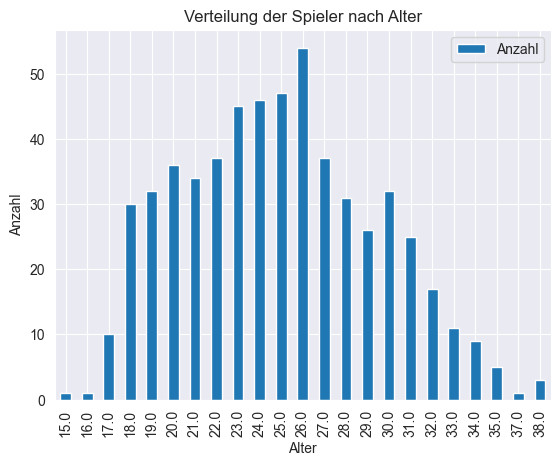

In [25]:
# Altersverteilung (der Spieler)
def altersverteilungen_nach_spielern(spieler_n_T):
    spieler_n_T = spieler_n_T[["Player","Age"]]
    alter = spieler_n_T.groupby(["Age"]).agg(
        Anzahl=("Player", "count"),
    )
    return alter
alter_nach_spielern = altersverteilungen_nach_spielern(spieler_n_T)
alter_nach_spielern.plot(kind="bar")
plt.title("Verteilung der Spieler nach Alter")
plt.xlabel("Alter")
plt.ylabel("Anzahl")
plt.show()

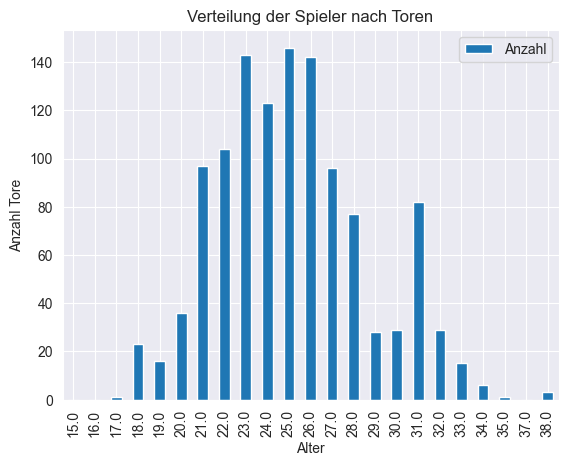

In [26]:
# Altersverteilung (nach Anzahl der Tore)
def altersverteilungen_nach_toren(spieler_n_T):
    spieler_n_T = spieler_n_T[["Player","Age","Goals"]]
    alter = spieler_n_T.groupby(["Age"]).agg(
        Anzahl=("Goals", "sum"),
    )
    return alter
alter_nach_toren = altersverteilungen_nach_toren(spieler_n_T)
alter_nach_toren.plot(kind="bar")
plt.title("Verteilung der Spieler nach Toren")
plt.xlabel("Alter")
plt.ylabel("Anzahl Tore")
plt.show()

In [27]:
# Altersstatistik nach Verein
def alter_nach_verein(spieler):
    spieler = spieler[["Player","Age","Team"]]
    verein = spieler.groupby("Team").agg(
        Durchschnitt=("Age", "mean"),
    )
    verein = verein.sort_values(by="Durchschnitt", ascending=True)
    return verein
alter_verein = alter_nach_verein(spieler)
alter_verein


,Durchschnitt
Team,
Chelsea,22.031250
Liverpool,23.833333
Sheffield,24.142857
Tottenham,24.172414
Burnley,24.290323
Brighton,24.366667
Manchester United,24.516129
Wolverhampton,24.592593
Bournemouth,24.633333


In [28]:
'''
Chelsea und Liverpool haben die jüngste Mannschaft der Liga - interessanter Gedanke: gibt es zwischen dem durchschnittalter und der Punkteanzahl eine Korrelation?
'''

'\nChelsea und Liverpool haben die jüngste Mannschaft der Liga - interessanter Gedanke: gibt es zwischen dem durchschnittalter und der Punkteanzahl eine Korrelation?\n'

In [29]:
# Gibt es eine Korrelation zwischen dem Durchschnittalter und der Anzahl an erzielten Punkte?
def alter_punkte_vergleich(spieler):
    spieler = spieler[["Player","Age","Team"]]
    verein_alter = spieler.groupby("Team").agg(
        Durchschnitt=("Age", "mean"),
    )
    path_tabelle = Path("finale_tabelle.csv")
    tabelle = pd.read_csv(path_tabelle)

    # Merging
    merging = pd.merge(tabelle, verein_alter, on="Team")
    merging = merging[["Team","Points","Durchschnitt"]]

    return merging
alter_punkte = alter_punkte_vergleich(spieler)
alter_punkte



,Team,Points,Durchschnitt
0,Manchester City,91,25.520000
1,Arsenal,89,24.800000
2,Liverpool,82,23.833333
3,Aston Villa,68,25.258065
4,Tottenham,66,24.172414
5,Chelsea,63,22.031250
6,Manchester United,60,24.516129
7,Newcastle United,60,25.343750
8,West Ham,52,27.000000
9,Crystal Palace,49,25.653846


In [30]:
'''
Hier wollte ich versuchen eine Korrelation zu finden zwischen dem Alter und der Anzahl an Punkte - bringt aber nix. Da gibt es keine Korrelation
'''

'\nHier wollte ich versuchen eine Korrelation zu finden zwischen dem Alter und der Anzahl an Punkte - bringt aber nix. Da gibt es keine Korrelation\n'

In [31]:
import numpy as np

In [32]:
# Als nächstes möchte ich einen Rotationsindex berechnen - auf welcher Position wurde am meisten rotiert? Auf welcher am wenigsten?
def rotationsindex(spieler):
    spieler = spieler[spieler["Position"].isin(["GK","FW","MF","DF"])].copy()
    rotation = spieler.groupby("Position").apply(lambda group: {
        "Total Minutes": group["Minutes Played"].sum(),
        "Standardabweichung": group["Minutes Played"].std(),
    })
    rotation = pd.DataFrame(rotation.values.tolist(),index=rotation.index)
    rotation["Rotationsindex"] = (rotation["Standardabweichung"] / rotation["Total Minutes"])

    rotation = rotation.sort_values(by="Rotationsindex", ascending=False)
    return rotation
rotationsindex(spieler)



C:\Users\maxim\AppData\Local\Temp\ipykernel_18392\3881990949.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rotation = spieler.groupby("Position").apply(lambda group: {


,Total Minutes,Standardabweichung,Rotationsindex
Position,,,
GK,68400.0,1175.905347,0.017192
FW,103484.0,1015.224606,0.009810
MF,144023.0,1062.665450,0.007378
DF,256496.0,975.009171,0.003801


In [33]:
# Jetzt kommt die Königsdisziplin: Wer war der Spieler der Saison?
'''
Aufgeteilt wird diese Analyse in 5 Kategorien:
1) Offensive Punkte: Auf Basis von Toren, Assists, Elfmeter-Toren und xG
2) Kreative Punkte: Spielaufbau, erwartete Assists usw
3) Defensive Punkte (auf Basis von Karten und Zweikämpfen)
4) Ausdauer Punkte (Hat der SPieler oft durchgespielt ( Anzahl der Minuten)
'''
def player_of_the_season(spieler_n_T):
    sds = spieler_n_T.copy()
    #1. Berechnung der offensiven Punkte
    sds["Offensive Punkte"] = ((
        5 * sds["Goals"] +
        3 * sds["Assists"] +
        2 * sds["Goals no Penalty"]) +
        2 * (sds["Goals"]/sds["xG"].replace(0,1))
    )
    #2. Berechnung der Kreativitätspunkte
    sds["Kreative Punkte"] = (
        0.3 * (sds["PrgP"]+sds["PrgR"]) +
        0.3 * sds["PrgC"] +
        0.3 * sds["xAG"]
    )
    #3. Berechnung der Defensivpunkte
    sds["Strafpunkte"] = (
        -2 * sds["Yellow Card"] -
        5 * sds["Red Card"]
    )
    # 4. Ausdauerpunkte
    sds["Ausdauer Punkte"] = (
        2 * sds["90 Mins Played"]
    )
    # Finale Punkte
    sds["Spieler der Saison"] = (
        0.6 * sds["Offensive Punkte"] +
        0.2 * sds["Kreative Punkte"] +
        sds["Strafpunkte"] +
        0.2 * sds["Ausdauer Punkte"]
    )
    return sds
sds_statistics = player_of_the_season(spieler_n_T)
sds_statistics = sds_statistics.sort_values(by="Spieler der Saison", ascending=False)
sds = sds_statistics[["Player","Spieler der Saison"]]
sds

,Player,Spieler der Saison
452,Phil Foden,137.397592
172,Erling Haaland,135.947589
505,Son Heung-min,135.428000
399,Mohamed Salah,131.766868
114,Cole Palmer,131.696549
...,...,...
115,Connor Roberts,-6.128000
308,Kalvin Phillips,-6.660000
367,Mason Holgate,-7.036000
564,Yves Bissouma,-7.276000


In [34]:
# Bester Offensivspieler
sds_offensive = sds_statistics[["Player","Offensive Punkte"]]
sds_offensive = sds_offensive.sort_values(by="Offensive Punkte", ascending=False)
sds_offensive

,Player,Offensive Punkte
172,Erling Haaland,191.849315
436,Ollie Watkins,174.261905
114,Cole Palmer,171.417582
452,Phil Foden,160.689320
505,Son Heung-min,147.833333
...,...,...
234,Jadon Sancho,0.000000
24,Alphonse Areola,0.000000
223,Ivo Grbić,0.000000
435,Oliver Skipp,0.000000


In [35]:
# Kreativster Spieler
sds_kreativ = sds_statistics[["Player","Kreative Punkte"]]
sds_kreativ = sds_kreativ.sort_values(by="Kreative Punkte", ascending=False)
sds_kreativ

,Player,Kreative Punkte
86,Bukayo Saka,239.85
143,Dejan Kulusevski,207.21
364,Martin Ødegaard,193.98
399,Mohamed Salah,179.34
505,Son Heung-min,178.44
...,...,...
61,Ben Doak,0.00
337,Loris Karius,0.00
523,Thomas Strakosha,0.00
72,Bernd Leno,0.00


In [36]:
# Unfaister Spieler
sds_unfair = sds_statistics[["Player","Strafpunkte"]]
sds_unfair = sds_unfair.sort_values(by="Strafpunkte", ascending=True)
sds_unfair

,Player,Strafpunkte
564,Yves Bissouma,-30.0
44,Anthony Gordon,-29.0
359,Mario Lemina,-29.0
39,Anel Ahmedhodžić,-27.0
356,Marcos Senesi,-26.0
...,...,...
111,Christopher Nkunku,-0.0
398,Mohamed Elneny,-0.0
486,Sam Curtis,-0.0
438,Omari Kellyman,-0.0


In [37]:
# Spieler mit der am meisten Gespielt hat
sds_ausdauer = sds_statistics[["Player","Ausdauer Punkte"]]
sds_ausdauer = sds_ausdauer.sort_values(by=["Ausdauer Punkte"], ascending=False)
sds_ausdauer

,Player,Ausdauer Punkte
246,James Tarkowski,76.0
72,Bernd Leno,76.0
285,Jordan Pickford,76.0
197,Guglielmo Vicario,76.0
382,Max Kilman,76.0
...,...,...
306,Kaide Gordon,0.0
250,Jamie Donley,0.0
242,James McConnell,0.0
154,Donny van de Beek,0.0
